In [1]:
import torch.utils.data as data_utils
from torchvision import datasets, transforms
import torch
from transformers import AutoImageProcessor, AutoModel
import matplotlib.pylab as plt
from PIL import Image
import requests
from tqdm import tqdm

In [2]:
dataset = datasets.MNIST('../datasets',
                      train=False,
                      download=True,
                      transform=None)

In [4]:
test_results = torch.load("../model_weights/mnst_mil_vallina/test_explain.pt")

In [5]:
test_results.keys()

dict_keys(['true_label', 'pred_label', 'masks', 'batch_indices', 'attention_scores'])

In [6]:
test_results["batch_indices"].shape, test_results["true_label"].shape, test_results["attention_scores"].shape, test_results["masks"].shape

(torch.Size([32000, 20]),
 torch.Size([32000]),
 torch.Size([32000, 1, 20]),
 torch.Size([32000, 20]))

In [7]:
select_index = 100
test_results["batch_indices"][select_index]

tensor([1445, 1722, 3352,  152, 2026, 7799, 2259, 5545,  350, 9632, 4750, 4430,
        6687, 1180, 4860, 5964, 6972, 9787, 7717, 7559])

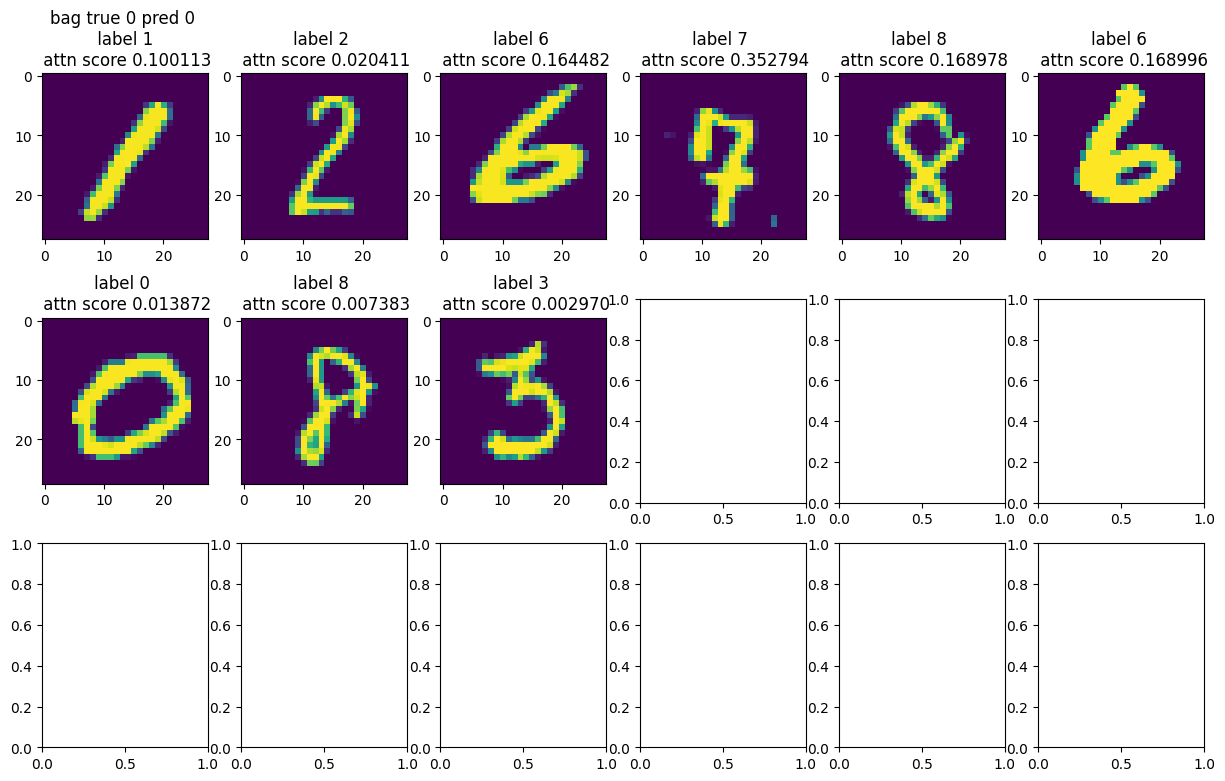

In [22]:
def transformer_attention_agg(attn, agg_fn="mean"):
    if agg_fn == "mean":
        return torch.mean(attn.view(12*41, 41), 0)[1:]
    elif agg_fn == "max":
        return torch.max(attn.view(12*41, 41), 0)[0][1:]
    elif agg_fn == "quantile":
        return torch.quantile(attn.view(12*41, 41), 0.90, 0)[1:]
    else:
        return torch.mean(attn.view(12*41, 41), 0)[1:]

def plot_scores(row, test_results):
    batch_indices = test_results["batch_indices"][row]
    imgs = [dataset[i_][0] for i_ in batch_indices]
    labels = [dataset[i_][1] for i_ in batch_indices]
    true_label = test_results["true_label"][row]
    pred_label = test_results["pred_label"][row]
    n = int(torch.sum(test_results["masks"][row]))
    n_cols = 6
    n_rows = 3
    # scores = transformer_attention_agg(test_results["attention_scores"][row], agg_fn="max")
    scores = test_results["attention_scores"][row][0]
    fig, ax = plt.subplots(n_rows, n_cols)
    fig.set_figwidth(15)
    fig.set_figheight(int(12/4 * n_rows))
    for i in range(n):
        ax[i//n_cols][i%n_cols].imshow(imgs[i])
        if i == 0:
            ax[i//n_cols][i%n_cols].set_title("bag true %i pred %i \n label %i \n attn score %f"%(true_label, pred_label, labels[i], scores[i]))
        else:
            ax[i//n_cols][i%n_cols].set_title("label %i \n attn score %f"%(labels[i], scores[i]))
plot_scores(13, test_results)

In [64]:
# torch.where(test_results["true_label"].eq(test_results["pred_label"]) == False)

In [65]:
# torch.max(attn.view(12*41, 41), 0)

In [15]:
test_results["attention_scores"][0][0]

tensor([4.3305e-01, 1.6726e-05, 1.4070e-06, 4.3021e-01, 9.7912e-08, 1.5700e-04,
        1.7469e-06, 1.9776e-07, 1.3358e-05, 1.0410e-05, 8.2862e-05, 8.2753e-05,
        9.9449e-06, 4.7885e-06, 1.3635e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00])